<a href="https://colab.research.google.com/github/kaleem500bc/Transformer/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import typing
from matplotlib import pyplot as plt
#For debugging
import pdb

#Hyperparamters
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 256
block_size = 64

learning_rate = 1e-3
dropout = 0.1
size_of_attention_head = 4
n_embd = 64
num_of_attention_head = 4

training_epochs = 10
eval_patience = 2

#Model is allowed to generate that much tokens
max_new_tokens = 100

#For reproduciblity
torch.manual_seed(1337)

#Download training set
!wget -O dataset.txt https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt

--2023-04-03 04:26:36--  https://raw.githubusercontent.com/udacity/deep-learning/master/tensorboard/anna.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2025486 (1.9M) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   1.93M  --.-KB/s    in 0.06s   

2023-04-03 04:26:36 (33.9 MB/s) - ‘dataset.txt’ saved [2025486/2025486]



In [20]:
dataset_path = "/content/dataset.txt"
with open(dataset_path, "r") as f:
  text = f.read()
text = text.replace("\n", " ").split()
vocabulary = sorted(list(set(text)))
vocab_size = len(vocabulary)

#Tokenize the vocab
stoi = {wrd:i for i, wrd in enumerate(vocabulary)}
itos = {i:wrd for i, wrd in enumerate(vocabulary)}

#Words to integers
def encode(string:list) -> torch.Tensor: 
  return torch.tensor([stoi[word] for word in string], dtype = torch.long, device=device)

#Integers to words
def decode(ints:list) -> str:
  return ' '.join([itos[i] for i in ints])


In [21]:
#Simple FeedForwad module
class FeedForward(nn.Module):
  def __init__(self, n_embd:int):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.net(x)

In [22]:
#Attention Head where relevance of each word in a context is calculated in relation to a given word
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)

    #Mask future token so they do not contribute while predicting the next token
    self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)

    # Scale values of Q*K gives more diffused values when apply softmax
    attention = q @ (k.transpose(-2,-1) * C**-0.5) 

    # Only token from the past contribute in predicting the next token
    attention = attention.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
    attention = F.softmax(attention, dim=-1)

    #For better regularization
    attention = self.dropout(attention) 

    v = self.value(x)
    attention = attention @ v
    return attention

In [23]:
#Instantiate multiple Attention Head
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    #Concatenate output of each Attention Head
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out


In [24]:
#A Block consist of MultiHeadAttention, LayerNorm and a FeedForward module
class Block(nn.Module):
  def __init__(self, n_embd, num_of_attention_head):
    super().__init__()
    head_size = n_embd // num_of_attention_head
    self.multiHeadAttention = MultiHeadAttention(num_of_attention_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)
  
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    #Skip connection and apply layerNorm
    x = x + self.multiHeadAttention(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


In [25]:
class LanguageModel(nn.Module):
  def __init__(self, args):
    super().__init__()
    vocab_size, n_embd, size_of_attention_head, training_dataloader, val_dataloader, path_model = args

    self.path_model = path_model

    self.training_dataloader = training_dataloader
    self.val_dataloader = val_dataloader
    self.train_len = len(training_dataloader)
    self.val_len = len(val_dataloader)

    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, num_of_attention_head=num_of_attention_head) for _ in range(size_of_attention_head)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)
  
  def forward(self, idx:torch.Tensor, targets:torch.Tensor=None) -> tuple:
    B, T = idx.shape
    token_emb = self.token_embedding_table(idx)

    #Encode positional embeding of a word in a sequence
    pos_emb = self.position_embedding_table(torch.arange(T, device=device))
    x = token_emb + pos_emb

    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  @torch.no_grad()
  def evaluate_model(self):
    eval_loss = 0
    self.eval()
    for input_seq, target_seq in self.val_dataloader:
      _, loss = self(input_seq, target_seq)
      eval_loss += loss.item()
    self.train()
    return eval_loss

  def train_model(self, epochs:int, optim, patience:int = 5):
    loss_per_epoch = []
    complete_eval_loss = [float('inf')]
    temp_patience = patience
    for epoch in range(epochs):

      epoch_loss = 0
      for input_seq, target_seq in self.training_dataloader:
        _, loss = self(input_seq, target_seq)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()

      epoch_loss = epoch_loss / self.train_len
      eval_loss = self.evaluate_model() / self.val_len

      print(f"Epoch {epoch}: {epoch_loss}, Evaluation Loss: {eval_loss}")

      if eval_loss < complete_eval_loss[-1]:
        complete_eval_loss.append(eval_loss)
        
        #Save model checkpoint if evaluation loss decreases
        torch.save(self.state_dict, self.path_model)
        temp_patience = patience

      elif temp_patience <= 0:
        return loss_per_epoch, complete_eval_loss[1:]
      else:
        temp_patience -= 1


      loss_per_epoch.append(epoch_loss)
    
    return loss_per_epoch, complete_eval_loss[1:]



  #idx are given tokens
  #max_new_tokens are maximum number of tokens that should be generated
  @torch.no_grad()
  def generate(self, idx:torch.Tensor, max_new_tokens:int) -> torch.Tensor:
    self.eval()
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    self.train()
    return idx


In [26]:
#Custom dataset
class Dataset(Dataset):

  def __init__(self, text: torch.Tensor, block_size: int):
    self.block_size = block_size
    self.len = len(text) - block_size

    #Raise exception if block size is less than length of the dataset
    if self.len < 0:
      raise Exception(f"Block Size {block_size} must be less then dataset size {len(text)}.")

    self.dataset = text.to(device)

  def __getitem__(self, idx:int) -> torch.Tensor:
    inputs = self.dataset[idx : idx+self.block_size]
    targets = self.dataset[idx+1 : idx+1+self.block_size]
    return inputs, targets

  def __len__(self):
    return self.len

#Encode text dataset to integers
encoded_text = encode(text)

#Instantiate dataset
dataset = Dataset(encoded_text, block_size)
train_set, val_set = random_split(dataset, [0.8, 0.2])

#Instantiate dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size)

In [27]:
filename_save_model = "language_model.pt"
args = [vocab_size, n_embd, size_of_attention_head, train_dataloader, val_dataloader, f"/content/sample_data/{filename_save_model}"]

language_model = LanguageModel(args)
language_model.to(device)

optim = torch.optim.AdamW(language_model.parameters(), lr = learning_rate)

In [ ]:
train_loss, eval_loss = language_model.train_model(training_epochs, optim, eval_patience)

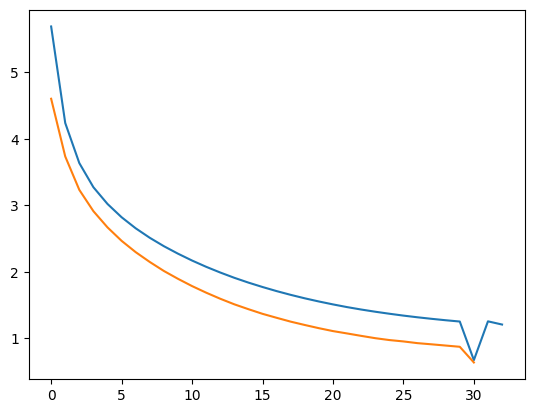

In [73]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.show()

In [74]:
language_model.eval()
input = "I was going to ".split()
input = encode(input).unsqueeze(0)
max_new_tokens = 100
print(decode(language_model.generate(input, max_new_tokens=max_new_tokens)[0].tolist()))

I was going to dinner, and so increase his young ladies prevented from being anything, she could not take him. "Oh, no," said Veslovsky, kissing Kitty's hand as though answering were on his lips him, and tears that she wanted to go to Dolly. "The shame, the bitterness of their Slavonic brethren, while you can, so well be, I don't know. But this will be in very well as usual at any of your illness and is not to forget it," said Alexey Alexandrovitch severely. Anna smiled. "Yes, I say what was saying. They have happy and could have thought that happy like her
